In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Load STL-10

In [18]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train data
trainset = torchvision.datasets.STL10(root='./data',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


# Show images

In [20]:
def show_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

horse  bird   dog   dog


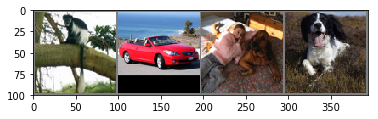

In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show_images(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Cut Images

In [7]:
def cut_torch_imgs(imgs, shape = (4,4)):
    # imgs is a batch of images -- expected n*c*h*w
    # shape is the shape of each piece
    # returns n*pieces*c*h*w
    assert len(imgs.shape) == 4,"Provide batches of inputs"
    assert not imgs.shape[2] % shape[0], "undivisible height for piece size"
    assert not imgs.shape[3] % shape[1], "undivisible width for piece size"
    
    a = imgs.transpose(1, 2).transpose(2,3).contiguous()
    c = a[0].shape[-1]
    x,y = a[0].shape[0]//shape[0], a[0].shape[1]//shape[1]
    b = a.view(-1,x,shape[0],y,shape[1],c)
    b = b.transpose(2,3).contiguous()
    b = b.view(-1,x*y,shape[0],shape[1],c)
    #transpose to torch accepted standard
    b = b.transpose(3,4).transpose(2,3)
    return b

In [8]:
s = cut_torch_imgs(images[0:4], (32,32))

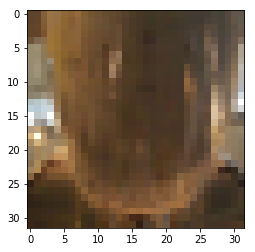

In [9]:
show_images(s[0][4])

In [10]:
images[0].shape

torch.Size([3, 96, 96])

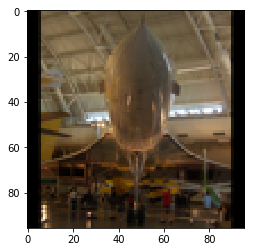

In [11]:
show_images(images[0])

# Models

In [12]:
vgg16 = models.vgg16(pretrained=True)

In [13]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [14]:
# model = nn.Sequential(*list(vgg16.features.children())[:24])
vgg_part = nn.Sequential(vgg16.features)

In [15]:
vgg_part

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
temp = vgg_part(s[0])

In [18]:
temp.view(s[0].shape[0],-1).shape, temp.shape

(torch.Size([9, 512]), torch.Size([9, 512, 1, 1]))

In [19]:
s[0].shape

torch.Size([9, 3, 32, 32])

# LSTM Test 1

In [20]:
torch.randn(1, 1, 3)

tensor([[[-1.1343,  0.1457, -0.2057]]])

In [21]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension

(tensor([[[ 0.2674,  0.0484, -0.1311]]], grad_fn=<ViewBackward>), tensor([[[ 0.3899,  0.4882, -0.3603]]], grad_fn=<ViewBackward>))
(tensor([[[ 0.3534,  0.1999, -0.0251]]], grad_fn=<ViewBackward>), tensor([[[ 0.7435,  0.4875, -0.2771]]], grad_fn=<ViewBackward>))
(tensor([[[0.1149, 0.6962, 0.1501]]], grad_fn=<ViewBackward>), tensor([[[1.0852, 1.1871, 0.5306]]], grad_fn=<ViewBackward>))
(tensor([[[0.3438, 0.2534, 0.0165]]], grad_fn=<ViewBackward>), tensor([[[1.0068, 0.6213, 0.2857]]], grad_fn=<ViewBackward>))
(tensor([[[-0.0089,  0.0766, -0.2652]]], grad_fn=<ViewBackward>), tensor([[[-0.0109,  0.2509, -0.5618]]], grad_fn=<ViewBackward>))


In [22]:
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.2769,  0.0794, -0.1687]],

        [[ 0.0222,  0.1966, -0.0475]],

        [[ 0.0714,  0.6922,  0.1128]],

        [[ 0.2807,  0.2585,  0.0104]],

        [[-0.1358,  0.0782, -0.2776]]], grad_fn=<CatBackward>)
(tensor([[[-0.1358,  0.0782, -0.2776]]], grad_fn=<ViewBackward>), tensor([[[-0.1683,  0.2602, -0.5860]]], grad_fn=<ViewBackward>))


In [23]:
# Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

IndentationError: unexpected indent (<ipython-input-23-177dd6edcbf3>, line 2)

# Sai 

In [35]:
for param in vgg_part.parameters():
    param.requires_grad = False
vgg_part = torch.nn.DataParallel(vgg_part)

In [46]:
class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        global vgg_part
        super(JigsawNet, self).__init__()
        self.vgg = vgg_part
        self.fc1 = nn.Linear(9*512, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        vgg_out = []
        for i in range(x.shape[1]):
            vgg_out.append(self.vgg(x[i]))
            
        # Cat
        x = torch.cat(vgg_out, dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        return x

In [47]:
output = JigsawNet()

In [48]:
output(images[0:4])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got input of size [3, 96, 96] instead

In [37]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [38]:
n_epochs = 10
sinkhorn_iter = 10

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_stl10_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 15915921


NameError: name 'train_loader' is not defined

# jayanth